In [387]:
from keras.layers import MaxPool2D, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from matplotlib.image import imread
from PIL import Image, ImageFont
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import visualkeras
import random
import cv2
import os

In [388]:
meta_df = pd.read_csv("data/Meta.csv")
num_classes = meta_df.shape[0]
meta_path, classes = meta_df["Path"], meta_df["ClassLabel"]
font = ImageFont.truetype("arial.ttf", 15)
seed = 123

In [389]:
train_path = "data/Train/"
test_path = "data/Test/"

#### Traffic Signs Visualization

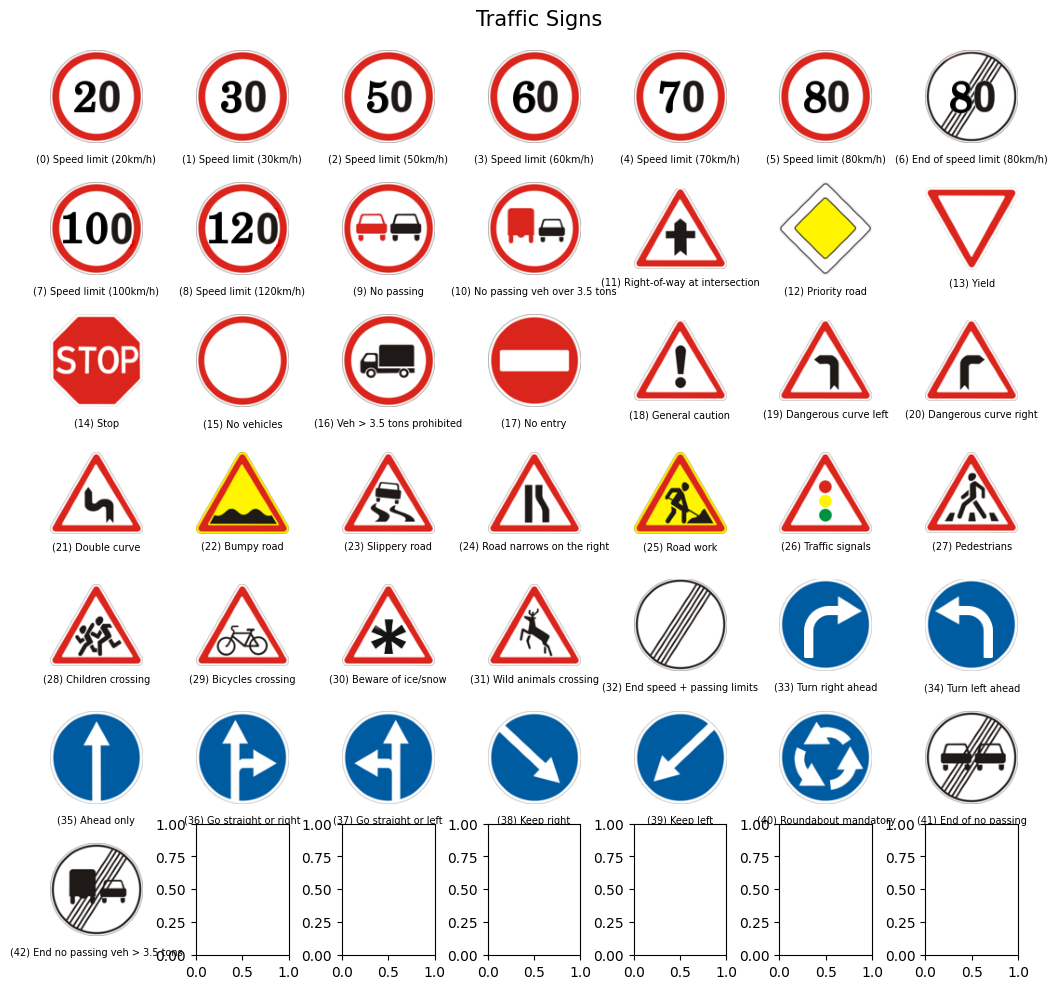

In [390]:
fig, ax = plt.subplots(7, 7, figsize=(10, 10))

for i, path in enumerate(meta_path):
    img = plt.imread("data/" + path)

    row, col = i // 7, i % 7

    ax[row, col].imshow(img)
    ax[row, col].axis("off")
    ax[row, col].set_title(f"({i}) {classes[i]}", fontdict={"fontsize": 7}, y=-0.3)

fig.suptitle("Traffic Signs", fontsize=15)
fig.subplots_adjust(top=1.5)
fig.tight_layout(pad=0.75)
plt.show()

#### Plotting the distribution of images among different classes in the training set

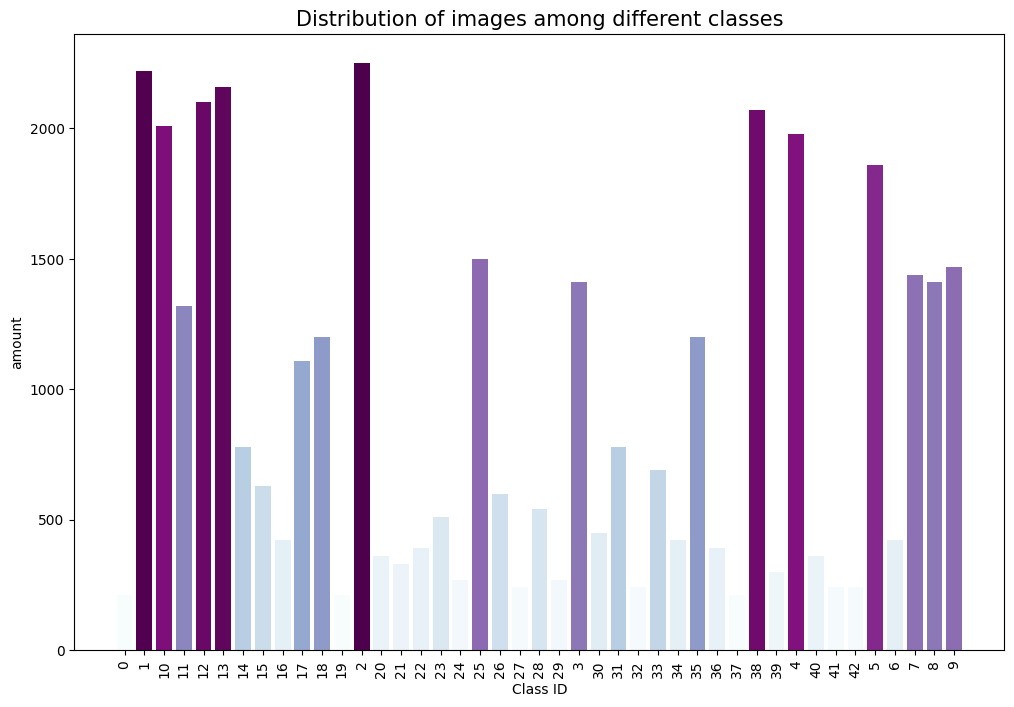

In [391]:
folders = os.listdir(train_path)

label_amount, class_num = [], []

for label in folders:
    train_files = os.listdir(train_path + "/" + label)
    label_amount.append(len(train_files))
    class_num.append(label)

cmap = plt.get_cmap("BuPu")
normalize = plt.Normalize(vmin=min(label_amount), vmax=max(label_amount))
colors = [cmap(normalize(value)) for value in label_amount]

plt.figure(figsize=(12, 8))
plt.bar(class_num, label_amount, color=colors)
plt.xticks(class_num, rotation="vertical")
plt.title("Distribution of images among different classes", fontsize=15)
plt.xlabel("Class ID")
plt.ylabel("amount")
plt.show()

#### Displaying random selection of test images with dimensions

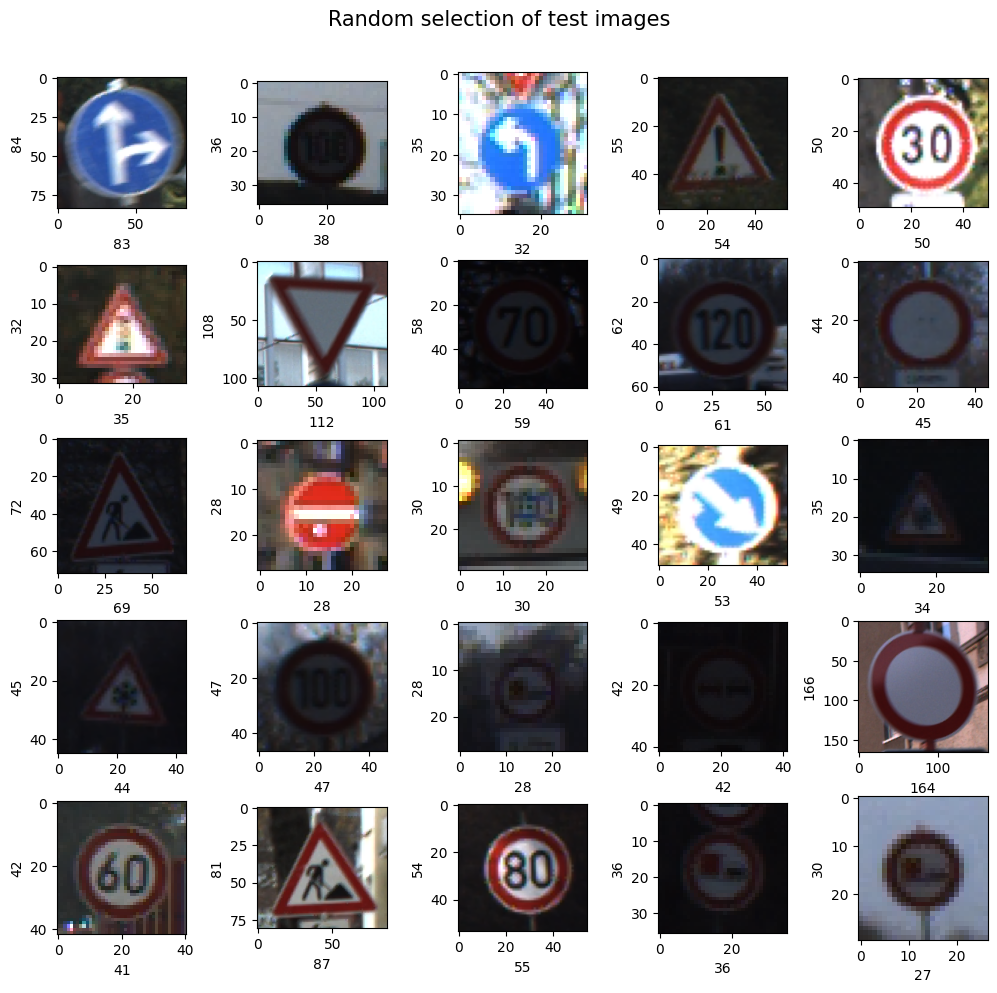

In [392]:
images_path = os.listdir(test_path)

fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(25):
    rand_img = imread(test_path + "/" + random.choice(images_path))

    row, col = i // 5, i % 5

    ax[row, col].imshow(rand_img)
    ax[row, col].set_xlabel(rand_img.shape[1], fontsize=10)
    ax[row, col].set_ylabel(rand_img.shape[0], fontsize=10)

fig.suptitle("Random selection of test images", fontsize=15)
fig.subplots_adjust(top=1.5)
fig.tight_layout(pad=0.8)
plt.show()

#### Data Loading

In [423]:
X_train_val, y_train_val = [], []

for label in range(num_classes):
    path = os.path.join(train_path, str(label))
    imgs = os.listdir(path)
    for img in imgs:
        image = Image.open(path + "/" + img)
        image = image.resize((30, 30))
        image = np.array(image)

        X_train_val.append(image)
        y_train_val.append(label)

X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)

print(X_train_val.shape, y_train_val.shape)

(39209, 30, 30, 3) (39209,)


In [424]:
test_df = pd.read_csv("data/Test.csv")

y_test, test_img_path = test_df["ClassId"].values, test_df["Path"].values
X_test = []

for img in test_img_path:
    image = Image.open("data/" + img)
    image = image.resize((30, 30))
    X_test.append(np.array(image))

X_test = np.array(X_test)

print(X_test.shape, y_test.shape)

(12630, 30, 30, 3) (12630,)


#### Data Splitting

In [425]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, shuffle=True,
                                                  random_state=seed)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(27446, 30, 30, 3) (11763, 30, 30, 3) (27446,) (11763,)


#### Preprocessing

In [426]:
def normalize(img):
    return cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def equalize(img):
    return cv2.equalizeHist(img)


def preprocess(img):
    img = normalize(img)
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

#### Preprocessing steps for sample image from training dataset

Text(0.5, 1.0, 'equalize')

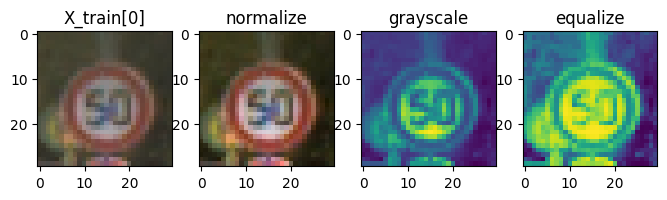

In [427]:
fig, ax = plt.subplots(1, 4, figsize=(8, 8))

img_sample = X_train[16]
ax[0].imshow(img_sample)

img_sample = normalize(img_sample)
ax[1].imshow(img_sample)

img_sample = grayscale(img_sample)
ax[2].imshow(img_sample)

img_sample = equalize(img_sample)
ax[3].imshow(img_sample)

ax[0].set_title("X_train[0]")
ax[1].set_title("normalize")
ax[2].set_title("grayscale")
ax[3].set_title("equalize")

In [428]:
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

In [429]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

#### Data Augmentation

In [430]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode="nearest")

#### One-hot encoding of class labels

In [431]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

#### Model Initialization

In [402]:
input_shape = (30, 30, 1)

In [403]:
LeNet5_model = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation="relu", input_shape=input_shape),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=120, activation="relu"),
    Dense(units=84, activation="relu"),
    Dense(units=num_classes, activation="softmax")
])

In [404]:
AlexNet_model = Sequential([
    # 1st Convolutional Layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding="same", input_shape=input_shape),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    # 2nd Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="same"),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    # 3rd Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same"),
    Activation("relu"),

    # 4th Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="same"),
    Activation("relu"),

    # 5th Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="same"),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    # Flatten the layers
    Flatten(),

    # 1st Dense Layer
    Dense(4096, input_shape=(30 * 30 * 1,)),
    Activation("relu"),
    Dropout(0.4),

    # 2nd Dense Layer
    Dense(4096),
    Activation("relu"),
    Dropout(0.4),

    # Output Layer
    Dense(num_classes),
    Activation("softmax")
])

In [405]:
MyModel_model = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu", padding="same", input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(5, 5), activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.1),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(rate=0.1),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(rate=0.2),
    Dense(128, activation="relu"),
    Dropout(rate=0.2),
    Dense(64, activation="relu"),
    Dropout(rate=0.2),
    Dense(32, activation="relu"),
    Dropout(rate=0.2),
    Dense(num_classes, activation="softmax")
])

#### Visualization of model architecture

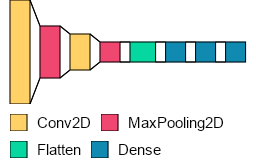

In [406]:
visualkeras.layered_view(LeNet5_model, legend=True, font=font, draw_volume=False)

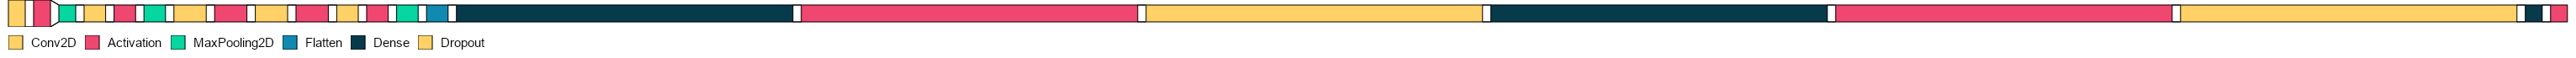

In [407]:
visualkeras.layered_view(AlexNet_model, legend=True, font=font, draw_volume=False)

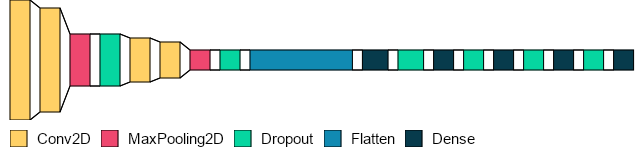

In [408]:
visualkeras.layered_view(MyModel_model, legend=True, font=font, draw_volume=False)

#### Model Training

In [409]:
def train_model(model, X_train, y_train, X_val, y_val, lr, batch_size, num_epochs):
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["accuracy"])

    model.summary()

    early_stop = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=num_epochs,
                        validation_data=(X_val, y_val), callbacks=[early_stop, lr_scheduler])

    return history

In [202]:
LeNet5_history = train_model(LeNet5_model, X_train, y_train, X_val, y_val, lr=1e-3, batch_size=32, num_epochs=50)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 26, 26, 6)         156       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 13, 13, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 9, 9, 16)          2416      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 120)             

In [230]:
AlexNet_history = train_model(AlexNet_model, X_train, y_train, X_val, y_val, lr=1e-3, batch_size=64, num_epochs=50)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156 (Conv2D)         (None, 8, 8, 96)          11712     
                                                                 
 activation_64 (Activation)  (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 4, 4, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_157 (Conv2D)         (None, 4, 4, 256)         614656    
                                                                 
 activation_65 (Activation)  (None, 4, 4, 256)         0         
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 2, 2, 256)        0         
 g2D)                                                

In [410]:
MyModel_history = train_model(MyModel_model, X_train, y_train, X_val, y_val, lr=1e-3, batch_size=32, num_epochs=50)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_232 (Conv2D)         (None, 30, 30, 32)        832       
                                                                 
 conv2d_233 (Conv2D)         (None, 26, 26, 32)        25632     
                                                                 
 max_pooling2d_110 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_62 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_234 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 conv2d_235 (Conv2D)         (None, 9, 9, 64)          36928     
                                                     

#### Plotting history of each model

In [411]:
def plot_history(model_history, model_name):
    pd.DataFrame(model_history.history).plot(figsize=(8, 6))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(f"{model_name} history")
    plt.show()

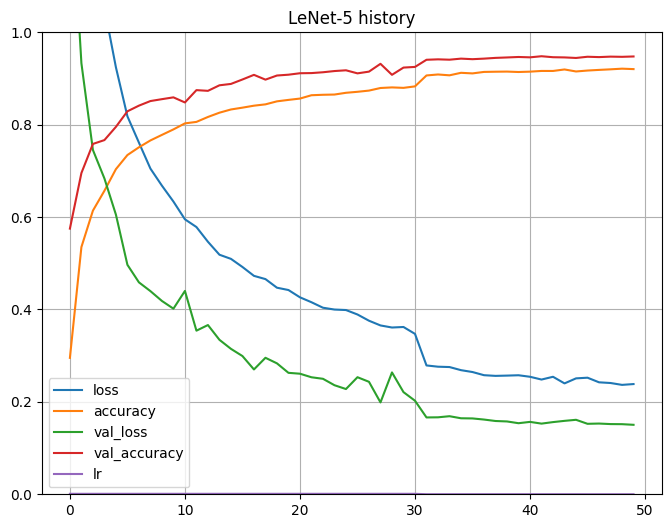

In [412]:
plot_history(LeNet5_history, "LeNet-5")

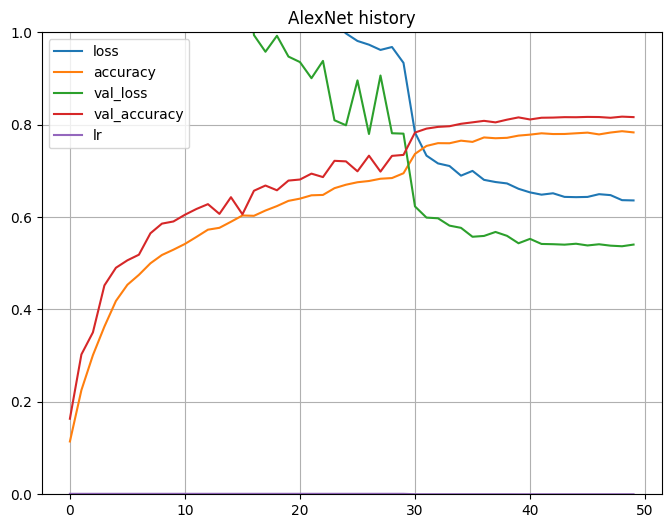

In [413]:
plot_history(AlexNet_history, "AlexNet")

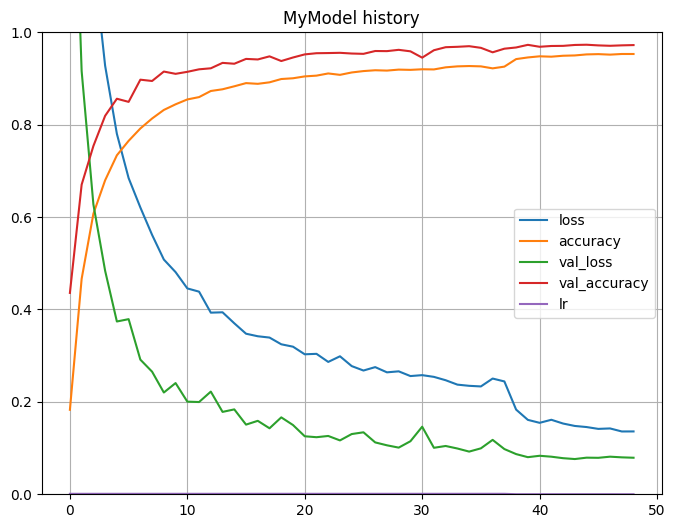

In [414]:
plot_history(MyModel_history, "MyModel")

#### Evaluation on validation data

In [435]:
LeNet5_val_loss, LeNet5_val_acc = LeNet5_model.evaluate(X_val, y_val)
AlexNet_val_loss, AlexNet_val_acc = AlexNet_model.evaluate(X_val, y_val)
MyModel_val_loss, MyModel_val_acc = MyModel_model.evaluate(X_val, y_val)

368/368 [==============================] - 6s 16ms/step - loss: 0.0762 - accuracy: 0.9725


#### Plotting Validation Metrics for Multiple Models

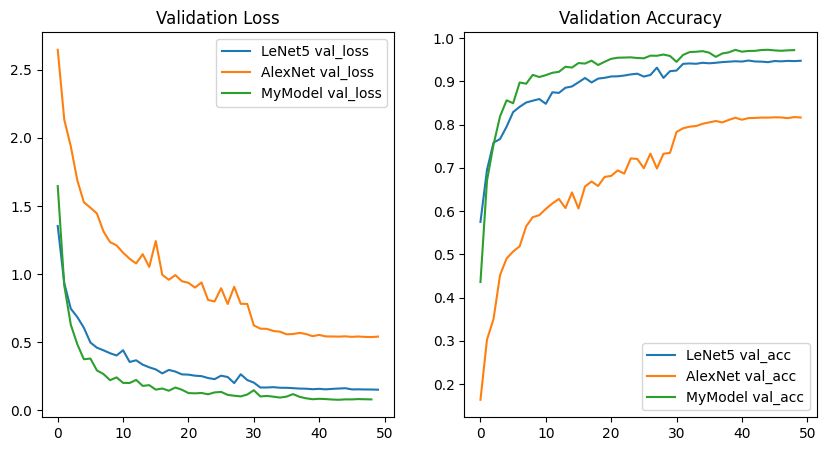

In [433]:
models = [LeNet5_history, AlexNet_history, MyModel_history]
models_name = ["LeNet5", "AlexNet", "MyModel"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for model, name in zip(models, models_name):
    # Plot validation loss
    axs[0].plot(model.history["val_loss"], label=f"{name} val_loss")

    # Plot validation accuracy
    axs[1].plot(model.history["val_accuracy"], label=f"{name} val_acc")

# Set titles and legends
axs[0].set_title("Validation Loss")
axs[0].legend()
axs[1].set_title("Validation Accuracy")
axs[1].legend()

plt.show()

#### Selecting the best model

In [436]:
val_losses = [LeNet5_val_loss, AlexNet_val_loss, MyModel_val_loss]
val_accs = [LeNet5_val_acc, AlexNet_val_acc, MyModel_val_acc]
best_model_idx = np.argmax(val_accs)
best_model_name = ["LeNet-5", "AlexNet", "MyModel"][best_model_idx]
print("The best model is:", best_model_name)

The best model is: MyModel


#### Evaluation of best model on test data

In [437]:
best_model = [LeNet5_model, AlexNet_model, MyModel_model][best_model_idx]
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test loss of the best model:", test_loss)
print("Test accuracy of the best model:", test_acc)

395/395 [==============================] - 6s 16ms/step - loss: 0.1841 - accuracy: 0.9473
Test loss of the best model: 0.18412216007709503
Test accuracy of the best model: 0.9472684264183044


In [438]:
# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = to_categorical(y_pred, num_classes)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average="weighted", zero_division=1)
recall = recall_score(y_test, y_pred, average="weighted", zero_division=1)
f1 = f1_score(y_test, y_pred, average="weighted", zero_division=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

395/395 [==============================] - 7s 18ms/step
Precision: 0.9538666348513493
Recall: 0.9472684085510689
F1-Score: 0.9410230924271825


#### Plot confusion matrix

In [439]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

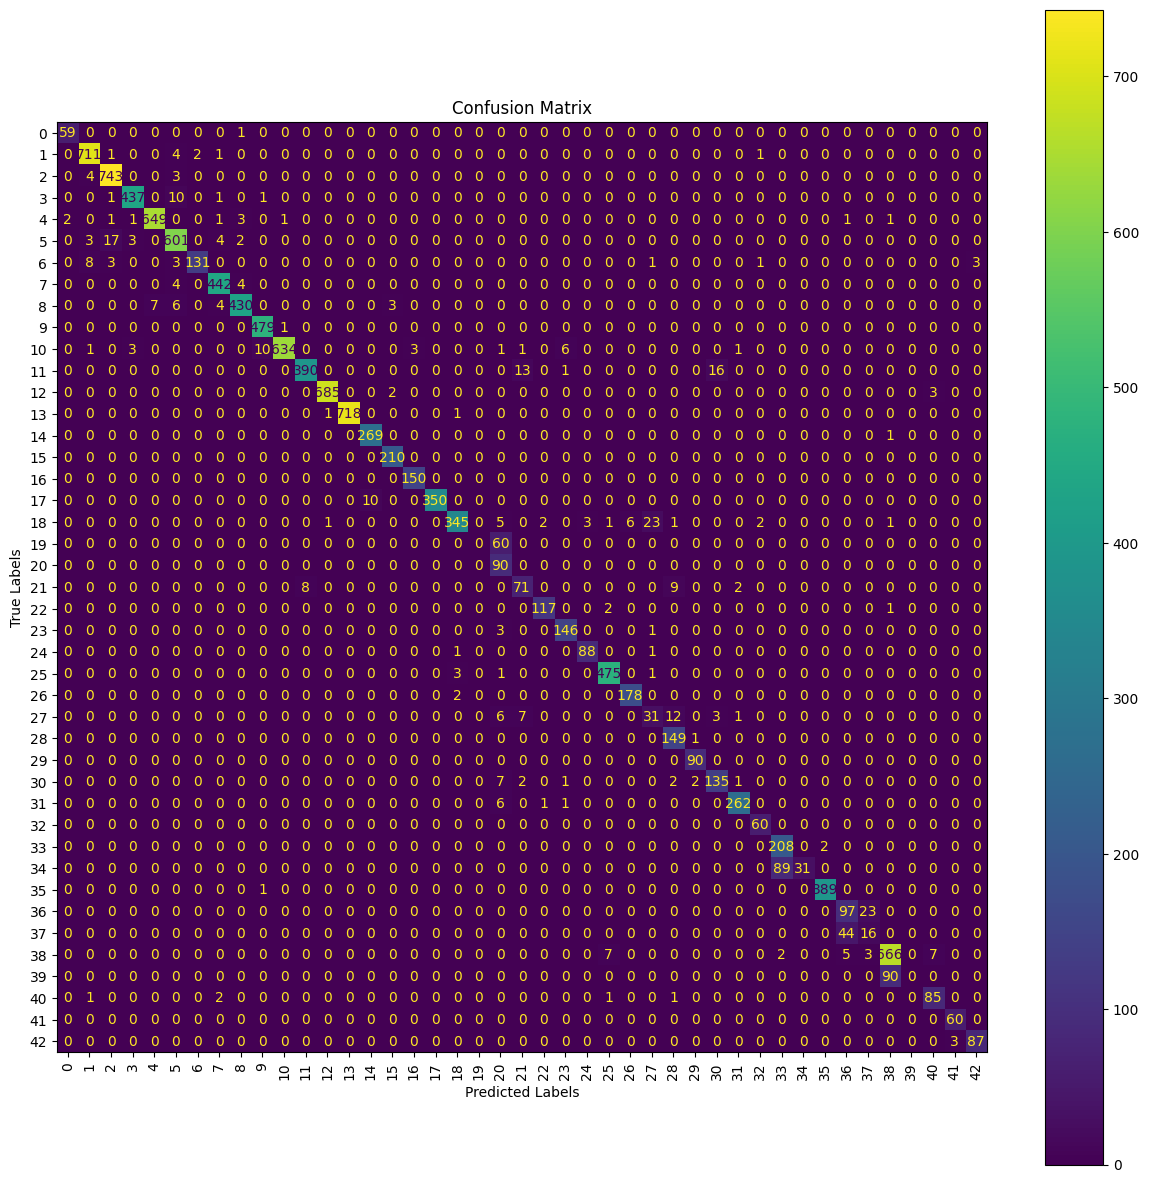

In [442]:
classes = list(range(num_classes))
cm = confusion_matrix(y_test, y_pred, labels=classes)

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax, xticks_rotation="vertical")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

plt.show()

#### Saving models

In [441]:
LeNet5_model.save("traffic_classifier_LeNet5.h5")
AlexNet_model.save("traffic_classifier_AlexNet.h5")
MyModel_model.save("traffic_classifier_MyModel.h5")